# Homework set 2

(Due Feb. 17, 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1: Optimal Photometry (50 pts)

We now turn to examples of applications of Maximum Likelihood in astronomy. 

We'll look at two cases: simple photometry and simultaneous fitting of galaxy size and total flux. We've all seen magnitudes in papers and catalogs... but where do they come from?

#### The setup of this problem is a bit long but hey, I've written the code for you.

## A star and a point spread function

The stars in images are not point sources *in the images*, despite being trillions of kilometers from us. This is because as the light from the stars meet travel to meet their fate on our CCD detectors here on Earth, it gets spread out from a perfect point.

The **Point Spread Function** (the "PSF") is comprised of various contributions: from minute misalignments in the optics, to jitter in the tracking, to diffraction from the spider, to diffusion of the electrons as they travel through the silicon in the CCD ("charge diffusion"), to the homogenization of the PSF due to the refraction and diffraction in the atmosphere.  

The dominant effect is the one ***from the atmosphere***.

![PSF Formation](psf-formation.jpg)

In practice, we don't construct the PSF from *ab initio* considerations because it's impractical to track each of these effects separately.

Instead, we measure it by looking at the observed shape of bright, isolated, point sources (i.e., stars). Those observations are noisy, so we fit analytical profiles to estimate the true PSF.

###  For simplicity, we will use just a single bivariate Gaussian here. This is our model.

We'll generate some data for a single source. It'll be stored in a variable named `image`
You can see the true parameters of the image 

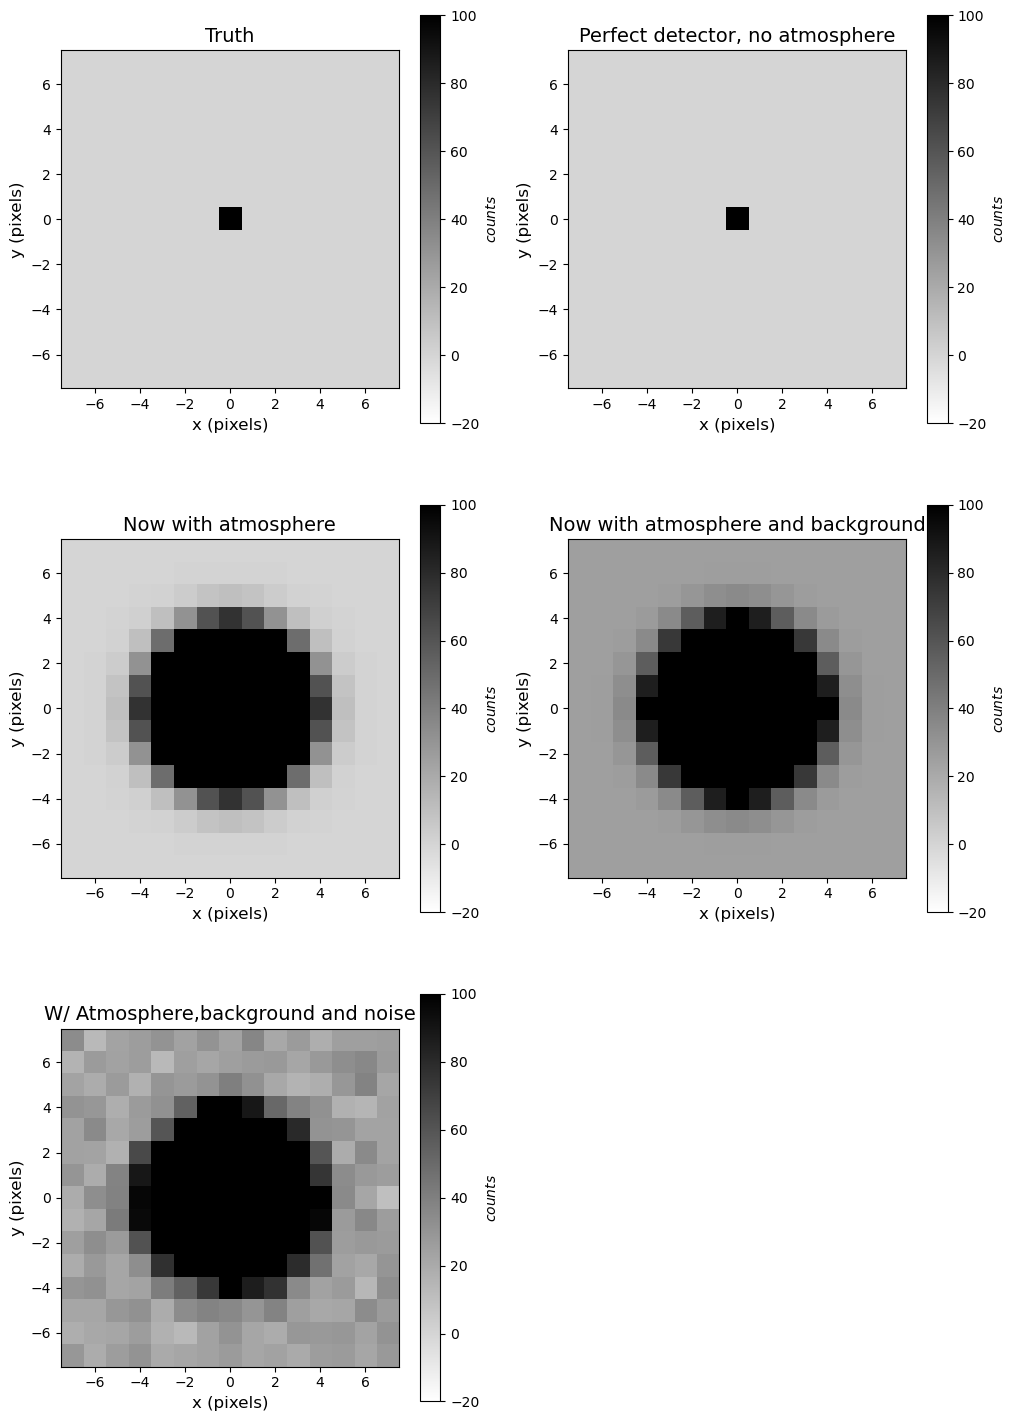

In [39]:
# DO NOT ALTER THE CODE IN THIS CELL - THIS BUILDS YOUR SIMULATION:
import numpy as np
import math
import matplotlib.pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev
np.random.seed(seed=42)

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect=1)
    plt.clim(-20, 100)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


# These will be the parameters of our image:

Atrue = 10000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 25        # sky background


def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./(sigmaPSF**2.)) / (np.sqrt(2.*math.pi)*sigmaPSF)
    return psf

fig = plt.figure(figsize=(12,18))

# uniform flux
image = np.zeros((xdim, ydim))
image[7,7] = Atrue
plotCutout(image, loc=321, fig=fig, title="Truth")

# random Poisson process
image = np.zeros((xdim, ydim))
image[7,7] = np.random.poisson(Atrue)
plotCutout(image, loc=322, fig=fig, title="Perfect detector, no atmosphere")

# PSF 
image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
plotCutout(image, loc=323, fig=fig, title="Now with atmosphere")

# PSF with background
image += skyBg
plotCutout(image, loc=324, fig=fig, title="Now with atmosphere and background")

# PSF with background and noise
image = np.random.poisson(image)
plotCutout(image, loc=325, fig=fig, title="W/ Atmosphere,background and noise")

simulatedImage = image

## Photometry (measuring the flux)

We now have an image that we observe, and some ***understanding of the processes that created it***.
We have encoded that understanding into a model.
This means you can now use maximum likelihood to estimate the parameters of the underlying source - like the total area under the profile - a measurement of how much light we received from the source, or it's `FLUX`

The `MAG_PSF` you plotted from the SDSS HLC files last week is directly related to the flux by $-2.5*log_{10}(\text{Flux}) + \text{Constant}$

## PSF Photometry: A Maximum Likelihood estimation of the flux

So our **model** for the image is that it consists of a Gaussian with a flux normalization fo $A$ , plus the background (which we've removed), plus the Gaussian noise (caused by photon quantization).

So, <u>**once the background is removed**</u>, for ***each pixel*** I can write:

>$ I(x,y) = A * PSF(x - x_0, y - y_0) + r_i $

where $A$ is the flux of the star (i.e. the thing we want), and $r_i$ is drawn from a Gaussian with

>$N(0, \sigma_{x,y} = \sqrt{I_{x,y} + B})$

and $B$ is the sky background. It's critical not to forget the background when computing the sigma -- for faint sources, this is where most of the measurement uncertainty comes from!

### For a single pixel 

### $$
\begin{align}
p(I(x_i, y_i)|A, PSF(x_i-x_0, y_i-y_0), \sigma) &= N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

### For a whole image then $p1 \times p2 \times p3$....

### $$ 
\begin{align}
P &= \Gamma p(I(x, y)|A, PSF(x_i-x_0, y_i-y_0), \sigma) \\
& = N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

Note this is practically identical to our case with fitting a line, except that instead of having one index $i$, we have two indices for the data points, $(x, y)$. And ***each pixel*** is an independent data point that constrains our model.

So we can readily write out the log-likelihood as:

### $$\ln{L} = \text{constant} - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$$

As we've seen , maximizing the likelihood of a product of normal distribution reduces to minimizing the $\chi^2$, which is what you'll do next.

## Q1.1 Assume the noise is constant, and minimize the log-likelihood analytically.  (5 pts)
(i.e. some calculus required)

You may wish to define these quantities:

>$\phi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot PSF_{x,y,\sigma_{PSF}}$
                             
>$\psi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} PSF_{x,y,\sigma_{PSF}}^2$


Looking at the form of $\phi_{x,y}$ and considering it for each pixel **what does it represent?** 

### A1.1

$\phi_{x,y}$ represents the total intensity of the image. 

Minimizing $-\ln L$ to determine the flux normalization $A$:

Note: given the desired minimization of $\chi^2$, the constant can be ignored.

$\begin{align}
-\ln{L} &= \text{constant} + \sum_{i=1}^N \frac{\left(I_{xy}- A\  \mathrm{PSF}_{x,y,\sigma_{PSF}}\right)^2}{2 \sigma^2} \\
       & \text{When minimizing the constant will be neglible, so I will ignore it here} \\
       &\approx  \sum_{i=1}^N \frac{\left(I_{xy}- A\  \mathrm{PSF}_{x,y,\sigma_{PSF}}\right)^2}{2 \sigma^2} \\
       & \text{Assuming the noise is constant} \\
       &\approx  \frac{1}{2 \sigma^2}\sum_{i=1}^N \left(I_{xy}- A\  \mathrm{PSF}_{x,y,\sigma_{PSF}}\right)^2 \\
       &\approx  \frac{1}{2 \sigma^2}\sum_{i=1}^N I_{xy}^2 - 2AI_{xy}\mathrm{PSF}_{x,y,\sigma_{PSF}} + A^2\mathrm{PSF}_{x,y,\sigma_{PSF}}^2\\
       &\approx  \frac{1}{2 \sigma^2}\big[ \sum_{i=1}^N I_{xy}^2 - 2A\sum_{i=1}^N I_{xy}\mathrm{PSF}_{x,y,\sigma_{PSF}} + A^2\sum_{i=1}^N \mathrm{PSF}_{x,y,\sigma_{PSF}}^2\big] \\
       & \text{Let: }\phi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot \mathrm{PSF}_{x,y,\sigma_{PSF}}, \psi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} \mathrm{PSF}_{x,y,\sigma_{PSF}}^2\\
       &\approx \frac{1}{2 \sigma^2}\sum_{i=1}^N (I_{xy}^2) - A\phi_{x,y} + \frac{A^2}{2}\psi_{x,y} \\
\end{align}$

Find the minimum, with respect to $A$:

$\begin{align}
\frac{d}{dA} -\ln L &= \frac{d}{dA} \frac{1}{2 \sigma^2}\sum_{i=1}^N I_{xy}^2 - A\phi_{x,y} + \frac{A^2}{2}\psi_{x,y} = 0\\
                  0 &= -\phi_{x,y} + A\psi_{x,y}\\
                  A &= \frac{\phi_{x,y}}{\psi_{x,y}} \\
                    &= \frac{\frac{1}{2\sigma^2}\sum_{i=1}^N I_{x,y}\cdot \mathrm{PSF}_{x,y,\sigma_{PSF}}}{\frac{1}{2\sigma^2}\sum_{i=1}^N  \mathrm{PSF}_{x,y,\sigma_{PSF}}^2}\\
                    &= \frac{\sum_{i=1}^N I_{x,y}\cdot \mathrm{PSF}_{x,y,\sigma_{PSF}}}{\sum_{i=1}^N  \mathrm{PSF}_{x,y,\sigma_{PSF}}^2}\\
\end{align}$

In [64]:
# use simulated image to get the I(x,y)
psf = makePSF(image.shape, 0, 0, sigmaPSF)
A = (simulatedImage * psf).sum() / (psf**2).sum()

print(f"My analytical flux normalization is %.1f." % A)

My analytical flux normalization is 10268.0.


## Q1.2 Estimating the true flux (15 pts)

To estimate the true flux, we need to maximize the likelihood. That is equivalent to minimizing the $\chi^2$. 

* estimate the background in the image
* estimate the noise in our measurements (remember it's a Poisson process!)
* as with the straight line, estimate the true flux grid of A
* Destermine the chi-sq/DoF at each location on the A grid and plot it
* Compare the numerical estimate with your analytical estimate that you made with your answer to Q1.1

### A1.2a/b/c: Estimating the background and noise in the measurements

It can be assume that the background is uniform across all points and points on the edge are uncontaminated with the source, and thus an estimate of the background is the average of the flux away from the source.

Given the data is obtain through a Poisson process, the noise/error follows a poisson distribution. The standard deviation of a poisson of a given $\lambda$ is $\sqrt{\lambda}$, and in this case the counts of each pixel is $\lambda$. So the noise per pixel can be estimated by finding the standard deviation of the counts.

In [300]:
# average the top row to get an estimation of the background
background = simulatedImage[0].mean()

# estimate the noise - given it is a poisson process
noise = np.sqrt(simulatedImage)

# made a guess near the analytical solution
(amin, amax) = 5000, 15000
A = np.linspace(amin,amax, 200)

### A1.2d: Determine $\frac{\chi^2}{DoF}$ at each point of the A grid and plot it

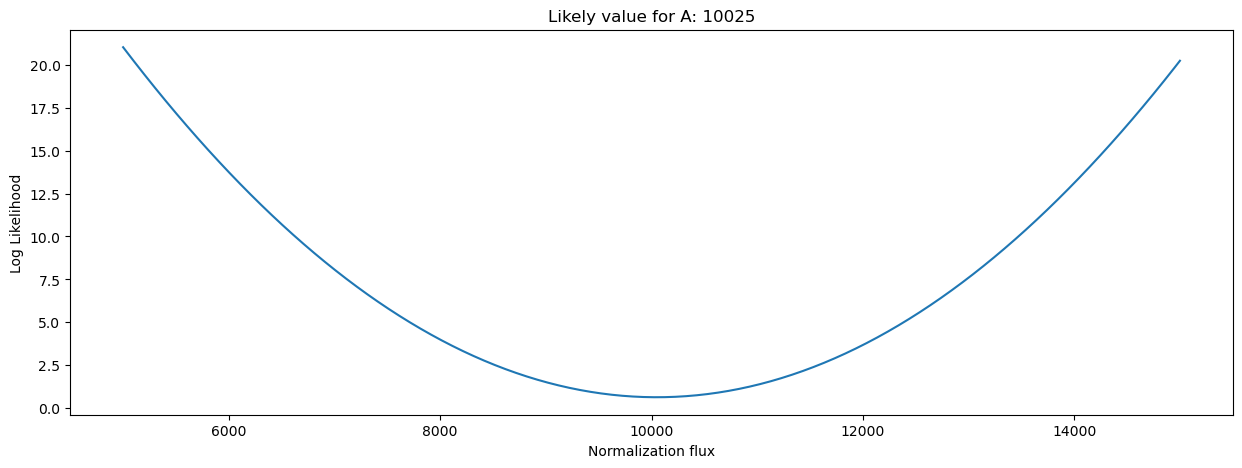

In [302]:
psf = makePSF(simulatedImage.shape, 0, 0, sigmaPSF)

dof = simulatedImage.size - 1 # N - k, N = number of points, k = number of parameters
likelihood = [((simulatedImage - background - (flux*psf))**2 / (2*dof*noise**2 )).sum() for flux in A]

fig = plt.figure(figsize=(15,5))
plt.plot(A, likelihood)
plt.xlabel("Normalization flux")
plt.ylabel("Log Likelihood")
plt.title(f"Likely value for A: %d"% A[np.argmin(likelihood)])
plt.show()

### A1.2e: Compare to analytical estimate

The analytical solution is the largest of the two solutions and its around 20% greater than the actual value, but the maximum likelihood solution is very close to the true value.

## Models with more parameters

The iterative example above is a bit contrived as we can, and did, solve the MLE analytically 

It has the benefit of being general, however. We can apply the same technique to models with more parameters (within the limits of computing power available to us!). The other parameters could be the position of the object ($x$, $y$), or some measure of the shape of the object.

As the number of parameters increases, the likelihood curve from the previous slide becomes the ***likelihood (hyper)surface***. The more dimensions there are, the more difficult (computationally expensive) it becomes to find its maximum using brute force solutions; even for 2D cases, we're likely to resort to ***minimization algorithms*** (e.g., Levenberg–Marquardt or others).

## Q1.3: Measuring the size and brightness of a spherical, gaussian, galaxy (30 pts)

Even in the ideal (space) case, a galaxy will not be a point source. We'll imagine we're dealing with a "Gaussian spherical galaxy" -- i.e., one whose intensity  falls of as a 2D gaussian would. As with the star, we'll asume the position of the galaxy is known.

Our model has two parameters: the measure of the extendedness of the galaxy -- $\sigma$ -- and its total flux, $C$:

>$ I(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $

We will now have to explore the likelihood surface in $(C, \sigma)$ space, and find the point of its maximum.

Note #2: When generating the simulated image, $I(x, y)$ needs to be ***convolved*** with the PSF. Fortunately (actually, because I'm lazy) we've chosen the galaxy profile to be gaussian, and the convolution of two gaussians with variances $\sigma_1^2$ and $\sigma_2^2$ is also a gaussian with the variance $\sigma_1^2 + \sigma_2^2$ (i.e., it's wider). 

Our function `gauss2D` utilizes this fact to generate the convolved image of the galaxy.

* we will generate two cases with `gauss2D` below:
* using this image as your data evaluate the log-likelihood
    * in Q2, we only did this for the flux $A$
    * now you have two parameters $C$ and it's shape $\sigma$
    * evaluate the likelihood on this grid 
    
    `C = np.linspace(500, 1500, 101)`
    
    `Sigma = np.linspace(0, 2.5, 101)`
    
* plot the noiseless image and the PSF image, returned by `simulate`, `image` itself, and the difference between image and PSF image (also returned by simulate), and your estimated log-likehood surface

In [236]:
def gauss2D(muX, muY, sig, A, skyBg, sigPSF, Xpixels, Ypixels):
    """
    Generate an image of size (Xpixels, Ypixels) with
    a 2D circular Gaussian of total flux A
    with standard deviation sigma^2=sig^2 + sigPSF^2
    superimposed on a uniform background B and centered
    on (muX, muY).
    """
    r = np.sqrt((Xpixels-muX)**2 + (Ypixels-muY)**2)
    # make and set image to the background value
    image = np.empty(r.shape)
    image.fill(skyBg)

    ## now add circular gaussian profile (normalized to A)
    # source gauss convolved with single-gauss PSF  
    sigConvSquare = sig**2 + sigPSF**2
    image += A*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare)
    return image


def addnoise(inimage, sigNoise, sourceImage, addsourcenoise=0): 
    """Add gaussian noise to the image, and return the image and variance plane"""
    image = np.copy(inimage)
    image += np.random.normal(0, sigNoise, image.shape)
    variance = 0*image + sigNoise**2

    if (addsourcenoise):
        gain = 1.0  # as a reminder...
        sourceVariance = sourceImage/gain
        image += np.random.normal(0, np.sqrt(sourceVariance), image.shape)
        variance += sourceVariance

    return image, variance 


def simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise):
    # set seed
    np.random.seed(42)
    
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    ## make psf (sigtrue=0) 
    psf = gauss2D(muXtrue, muYtrue, 0, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)

    ## make noiseless image (convolved with psf given by sigmaPSF, image size given by 1Dpixels) 
    nonoise = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
 
    ## now add noise
    image, variance = addnoise(nonoise, sigmaNoise, 0) 

    ## difference object - psf
    diffimage = image - psf

    return nonoise, psf, image, diffimage


# Q1.3.a Case 1 - a sanity check - if sigtrue (i.e. the shape of the galaxy) is 0 we're back to dealing with a single star. (15 pts)

In [313]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 0.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 


nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

### A1.3a

In [314]:
def loglikelihood(psf, image):
    
    # estimate background/noise like above
    background = image[0].mean()
    noise = np.sqrt(image)
    
    # init grid
    limits = (0, 2.5, 500, 1500)
    sigma = np.linspace(limits[0], limits[1],101)
    C = np.linspace(limits[2], limits[3], 101)
    dof = image.size - 2 # 2 parameters this time
    
    # for model -- square grid from simulate
    xpix = np.linspace(-7, 7, 15)
    
    # make a place to put the likelihoods for each combination
    likelihood = np.zeros((C.size, sigma.size)) 
    # loop through each combination
    for i, c in enumerate(C):
        for j, s in enumerate(sigma):
            # centered on 0,0 with sigma = s, flux = c, using pixels like from simulate
            model = gauss2D(0,0, s, c, background, sigmaPSF, xpix[:, np.newaxis], xpix)
            # calc likelihood - chi^2 / 2(N-k)
            likelihood[i][j] = (((image - model)**2) / (2*dof*noise**2)).sum()
            
    # get the (c,sigma) corresponding to the smallest likelihood
    idx = np.unravel_index(np.argmin(likelihood, axis=None), likelihood.shape)
    
    bestfit = (C[idx[0]], sigma[idx[1]])
    return likelihood, limits, bestfit

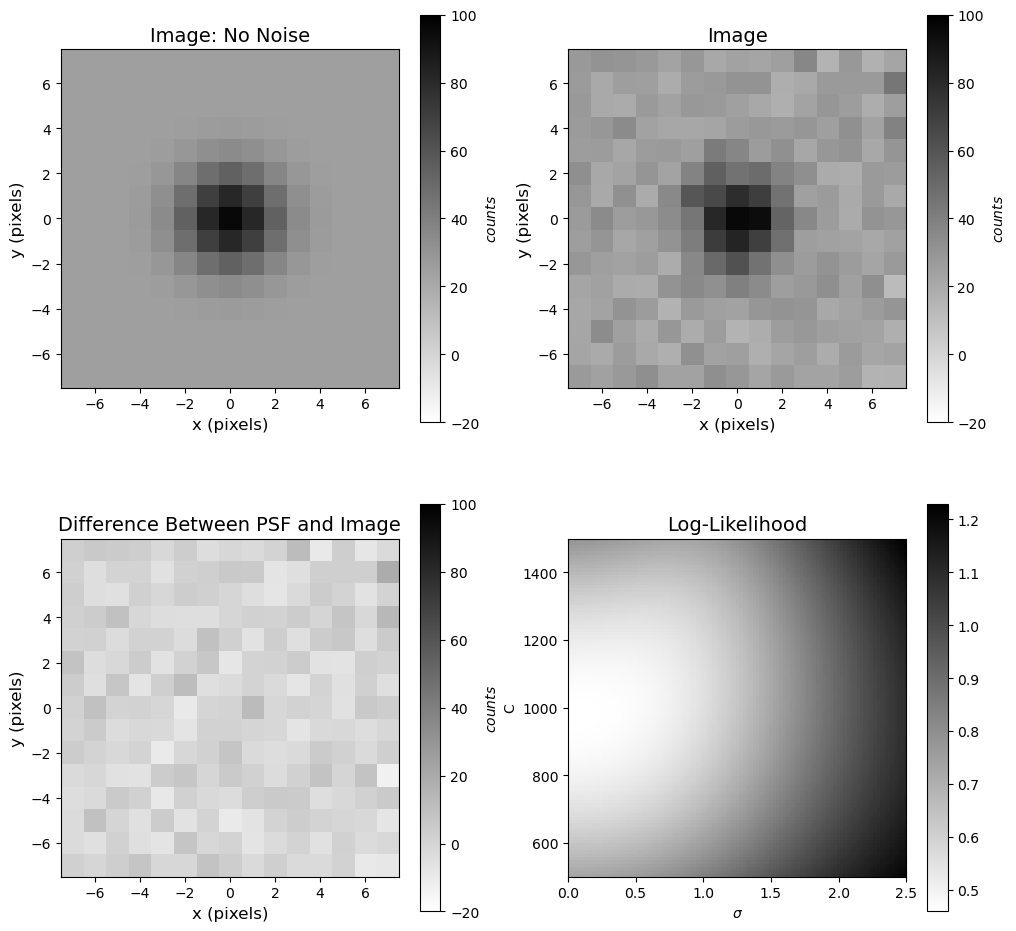

My best estimate for (C,sigma) is (980, 0.0)


In [315]:
# calc likelihood
likelihood, limits, bestfit = loglikelihood(psf, image)

# the plot all that stuff here
fig = plt.figure(figsize=(12,18))
plotCutout(nonoise, loc=321, fig=fig, title="Image: No Noise")
plotCutout(image, loc=322, fig=fig, title="Image")
plotCutout(diffimage, loc=323, fig=fig, title="Difference Between PSF and Image")
ax = fig.add_subplot(324)
plt.imshow(likelihood, origin='lower', interpolation='nearest', extent=limits, cmap=plt.cm.binary, aspect=((2.5-0)/(1500-500)))
plt.title("Log-Likelihood", fontsize=14)
plt.xlabel(r"$\sigma$")
plt.ylabel("C")
plt.colorbar()
plt.show()

print(r"My best estimate for (C,sigma) is (%d, %.1f)" % bestfit)

# Q1.3.b Case 2 - if sigtrue is non-zero, we're dealing with a spherical cow galaxy (15 pts)

In [316]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 1.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 

nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

### A1.3b

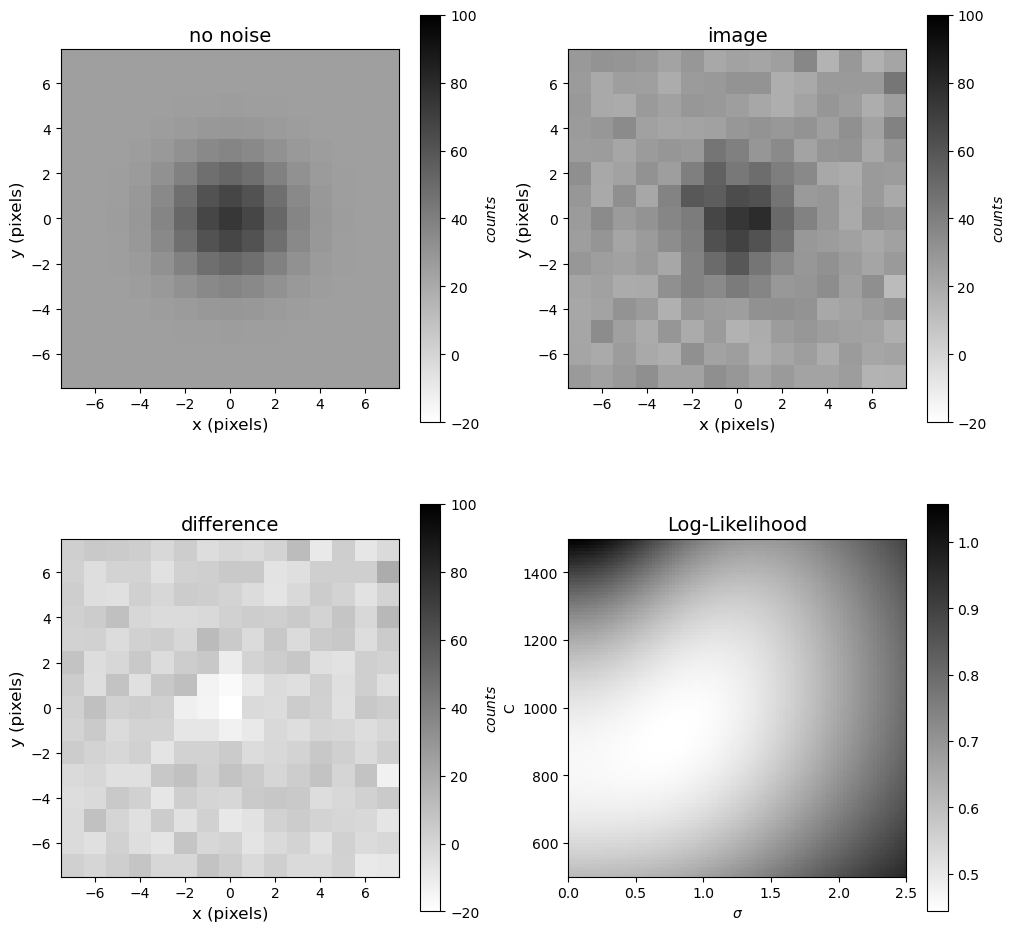

My best estimate for (C,sigma) is (910, 0.8)


In [317]:
# same calc, just new image
likelihood, limits,bestfit = loglikelihood(psf, image)

# the plot all that stuff here
fig = plt.figure(figsize=(12,18))
plotCutout(nonoise, loc=321, fig=fig, title="no noise")
plotCutout(image, loc=322, fig=fig, title="image")
plotCutout(diffimage, loc=323, fig=fig, title="difference")
ax = fig.add_subplot(324)
plt.imshow(likelihood, origin='lower', interpolation='nearest', extent=limits, cmap=plt.cm.binary, aspect=((2.5-0)/(1500-500)))
plt.title("Log-Likelihood", fontsize=14)
plt.xlabel(r"$\sigma$")
plt.ylabel("C")
plt.colorbar()
plt.show()

print(r"My best estimate for (C,sigma) is (%d, %.1f)" % bestfit)

## Problem 2

Last week you showed that Bayesian and Frequentist approaches are often equivalent for simple problems (after all you implicitly had a prior in the form of a grid). 

But it is also true that they can diverge greatly. In practice, this divergence makes itself most clear in two different situations:

1. The handling of "nuisance parameters"
2. The subtle (and often overlooked) difference between frequentist confidence intervals and Bayesian credible intervals

Here, we focus on the first point: the difference between frequentist and Bayesian treatment of nuisance parameters.


## What is a Nuisance Parameter?

***A nuisance parameter is any quantity whose value is not relevant to the goal of an analysis, but is nevertheless required to determine some quantity of interest***.

For example, last week, in problem 3, we estimated both the mean $C$ and shape $\sigma_\text{source}$ for some spherical cow galaxy. Now the shape might be important, but in homework 1, you only needed the brightness of the sources where you plotted up $r$ vs $g-i$ for galaxies (you needed the shape to separate stars from galaxies in the form of MEAN_OBJECT_TYPE, but that's it).

As far as you were concerned in homework 1, the shape was a **nuisance** parameter.


## A Classic Problem:


We'll start with an example of nuisance parameters that, in one form or another, dates all the way back to the posthumous [1763 paper](http://www.stat.ucla.edu/history/essay.pdf) written by Thomas Bayes himself. The particular version of this problem we'll study is borrowed from [Eddy 2004](ftp://selab.janelia.org/pub/publications/Eddy-ATG3/Eddy-ATG3-reprint.pdf).


The setting is a rather contrived game in which Alice and Bob bet on the outcome of a process they can't directly observe:

> Alice and Bob enter a room. Behind a curtain there is a billiard table, which they cannot see, but their friend Carol can. Carol rolls a ball down the table, and marks where it lands. Once this mark is in place, Carol begins rolling new balls down the table. If the ball lands to the left of the mark, Alice gets a point; if it lands to the right of the mark, Bob gets a point.  We can assume for the sake of example that Carol's rolls are unbiased: that is, the balls have an equal chance of ending up anywhere on the table.  **The first person to reach six points wins the game.**

Here ***the location of the mark (determined by the first roll) can be considered a nuisance parameter***.

It is unknown, and not of immediate interest, but it clearly must be accounted for when predicting the outcome of subsequent rolls. If the first roll settles far to the right, then subsequent rolls will favor Alice. If it settles far to the left, Bob will be favored instead.

Given this setup, here is the question we ask of ourselves:

> In a particular game, after eight rolls, Alice has five points and Bob has three points. What is the probability that Bob will go on to win the game?

Intuitively, you probably realize that because Alice received five of the eight points, the marker placement likely favors her. And given this, it's more likely that the next roll will go her way as well. 

And she has three opportunities to get a favorable roll before Bob can win; she seems to have clinched it.  But, **quantitatively**, what is the probability that Bob will squeak-out a win?


Someone following a classical frequentist approach might reason as follows:

To determine the result, we need an intermediate estimate of where the marker sits. We'll quantify this marker placement as a probability $p$ that any given roll lands in Alice's favor.  Because five balls out of eight fell on Alice's side of the marker, we can quickly show that the maximum likelihood estimate of $p$ is given by:

$$
\hat{p} = 5/8
$$

(This result follows in a straightforward manner from the [binomial likelihood](http://en.wikipedia.org/wiki/Binomial_distribution)). 

# 2.1 Under the assumptions of maximum likelihood, what is the probability of Bob winning the game - i.e. getting six points, and what are the odds 
# (i.e. $(1 - p_\text{Bob wins})/p_\text{Bob wins}$) (5 pts)

### A2.1

Given the probility that the ball lands in Alice's favor is $\hat{p} = 5/8$, then the probability it lands in Bob's favor is $1 - \hat{p} = 3/8$.

Then the probability of Bob winning is the same as the probabilty that the ball lands in his favor 3 more times: $p_\text{Bob wins} = (1-\hat{p})^3  =(3/8)^3$

Then the odds that Bob wins is as follows:

$\begin{align}
(1 - p_\text{Bob wins})/p_\text{Bob wins} &= (1 - (1-\hat{p})^3)/(1-\hat{p})^3 \\
                                          &= \frac{1-(\frac{3}{8})^3}{(\frac{3}{8})^3} \\
                                          &= \frac{1-\frac{27}{512}}{\frac{27}{512}} \\
                                          &= \frac{485}{27} \\
                                          &\approx 18:1 \\
\end{align}$

The odd's are approximately 18:1 against Bob winning; Alice is 18 times more likely to win before Bob.

We can also approach this problem from a Bayesian standpoint. This is slightly more involved, and requires us to first define some notation.

We'll consider the following random variables:

- $B$ = Bob Wins
- $D$ = observed data, i.e. $D = (n_A, n_B) = (5, 3)$
- $p$ = unknown probability that a ball lands on Alice's side during the current game

We want to compute $P(B~|~D)$; that is, the probability that Bob wins given our observation that Alice currently has five points to Bob's three.

The general Bayesian method of treating nuisance parameters is ***marginalization***, or integrating the joint probability over the entire range of the nuisance parameter. In this case, that means that we will first calculate the joint distribution
$$
P(B,p~|~D)
$$
and then marginalize over $p$ using the following identity:
$$
P(B~|~D) \equiv \int_{-\infty}^\infty P(B,p~|~D) {\mathrm d}p
$$
This identity follows from the definition of conditional probability, and the law of total probability: that is, it is a fundamental consequence of probability axioms and will always be true. Even a frequentist would recognize this; they would simply disagree with our interpretation of $P(p)$ as being a measure of uncertainty of our own knowledge.

To compute this result, we will manipulate the above expression for $P(B~|~D)$ until we can express it in terms of other quantities that we can compute.

We'll start by applying the following definition of [conditional probability](http://en.wikipedia.org/wiki/Conditional_probability#Definition) to expand the term $P(B,p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) P(p~|~D) dp
$$

Next we use [Bayes' rule](http://en.wikipedia.org/wiki/Bayes%27_theorem) to rewrite $P(p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) \frac{P(D~|~p)P(p)}{P(D)} dp
$$

Finally, using the same probability identity we started with, we can expand $P(D)$ in the denominator to find:

$$
P(B~|~D) = \frac{\int P(B~|~p,D) P(D~|~p) P(p) dp}{\int P(D~|~p)P(p) dp}
$$

Now the desired probability is expressed in terms of three quantities that we can compute. Let's look at each of these in turn:
<small>
- $P(B~|~p,D)$: This term is exactly the frequentist likelihood we used above. In words: given a marker placement $p$ and the fact that Alice has won 5 times and Bob 3 times, what is the probability that Bob will go on to six wins?  
    
    
- $P(D~|~p)$: this is another easy-to-compute term. In words: given a probability $p$, what is the likelihood of exactly 5 positive outcomes out of eight trials? The answer comes from the well-known [Binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution)
    
    
- $P(p)$: this is our prior on the probability $p$. By the problem definition, we can assume that $p$ is evenly drawn between 0 and 1.  That is, $P(p) \propto 1$, and the integrals range from 0 to 1.</small>

# 2.2 Evaluate that integral and get an expression in terms of $p$ (10 pts)

### A2.2

Getting the 3 component probabilities:

The probability Bob wins given the ball placement and data: $P(B~|~p,D) = (1 - p)^3$

The probability 5 out of 8 balls land in Bob's favor, which is the Binomial distribution where $n = 8, k = 5$ (8 choose 5): 

$\begin{align}
    P(D~|~p) &= \binom{n}{k} p^k(1-p)^{n-k} \\
             &= \frac{8!}{5!(8-5)!}p^5(1-p)^{8-5} \\
             &= 56 p^5(1-p)^{3} \\
\end{align}$

The probability of the ball placement: $P(p) = 1$ because we believe $P(p)$ to be a flat prior where all values of $p$ are equally likely. 

With all of this, the probability that Bob wins is:

$\begin{align}
    P(B|D) &= \frac{\int P(B~|~p,D) P(D~|~p) P(p) dp}{\int P(D~|~p)P(p) dp} \\
             &= \frac{\int (1 - p)^3\cdot 56 p^5(1-p)^{3} dp}{\int 56 p^5(1-p)^{3} dp} \\
             &= \frac{\int p^5(1-p)^{6} dp}{\int p^5(1-p)^{3} dp} \\
\end{align}$

The integrals you find might look a bit difficult, but they are just special cases of the [Beta Function](http://en.wikipedia.org/wiki/Beta_function):
$$
\beta(n, m) = \int_0^1 (1 - p)^{n - 1} p^{m - 1}
$$

scipy has an implementation of this in `scipy.special`.

# 2.3 Evaluate your expression numerically and compute the probability and the odds that Bob wins (15 pts)

### A2.3

In [248]:
from scipy.special import beta

# since exponents in the beta function are n-1 and m-1 -> n and m = exponent + 1
    # num: n = 7 (6+1), m = 6 (5+1)
    # denom: n = 4 (3+1), m = 6
P_BD = beta(7,6)/beta(4,6)

print(f"The numerial solution for the probability that Bob wins is %.3f and the odds of him losing to Alice are %d:1." % (P_BD, (1-P_BD)/P_BD) )

The numerial solution for the probability that Bob wins is 0.091 and the odds of him losing to Alice are 10:1.


# 2.4 Finally, lets check the result using an approach called Monte Carlo, where we simulate a bunch of games, and simply count the fraction of relevant games that Bob goes on to win. The current problem is especially simple because so many of the random variables involved are uniformly distributed. 

* Simulate 100,000 random p between 0 and 1 - this will be a 1D array
* given each p, to win the game needs *at most* 11 rolls - simulate 11 rolls for each p - this will be a 2D array
* count the cumultative wins for Alice and Bob at each roll - this is a 2D array
* determine which games has Bob with three points by the end of game 8 - this is a 1D array
* considering only these games, find the number of games which Bob won (i.e. has six points at the end of game 11)
* compute the total probability that Bob won, and the odds that Bob won.


## You don't need anything more than `numpy` to do this - in particular `numpy.random` and `numpy.cumsum` to do this.

# No for loops. (15 pts)

### A2.4

Each bullet has a comment corresponding to the code that answers it 

In [318]:
# 2.4a - marker placements
p = np.random.rand(100000)

# 2.4b - p x 11 rolls
    # assume the rolls of the ball follow the same process at the marker ie: can be in a position between [0,1)
rolls = np.random.rand(p.shape[0], 11)

In [319]:
# 2.4c - find bob wins
    # bob wins if roll > p
Bob_wins = np.apply_along_axis(lambda r: r > p, 0, rolls)

# sum bobs wins after each roll
cuml_bob_wins = np.apply_along_axis(lambda win: np.cumsum(win), 1, Bob_wins)

# 2.4d - get games where bob gets 3 points by ball 8 -- exactly equal?
three_pt_games = cuml_bob_wins[np.where(cuml_bob_wins[:, 7] == 3)]

# 2.4e - get bob wins (needs 6pts by last round)
won_games = three_pt_games[np.where(three_pt_games[:, -1] >= 6)]

#2.4f - fraction of relevant games won, and odds
prob_bob_won = len(won_games)/len(three_pt_games)
odds = (1 - prob_bob_won)/ prob_bob_won 

print(f"The probability that Bob won after only having 3 points by ball 8 is %.3f, and the odds are %.2f against Bob." % (prob_bob_won, odds))

The probability that Bob won after only having 3 points by ball 8 is 0.089, and the odds are 10.19 against Bob.


## 2.5 Why do the two results disagree? (5 pts)

### A2.5

The Monte Carlo and Bayesian approaches agree; however the analytical solution does not. This could be because the analytical solution does not consider how likely Bob was to be in that position.  The maximum likelihood solution takes $p$ to be $5/8$, where games with differing ball placements can still yeild wins for Bob.